## Imports

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import cv2
print('cv2.__version__:', cv2.__version__)  # 4.1.2 recommended

import numpy as np
from IPython import display

import sys, platform
import ctypes, ctypes.util
import shutil

import threading
import time
import logging
logging.basicConfig(level=logging.DEBUG, format='(%(threadName)-10s) %(message)s')

from thread_camera import WebcamVideoStream

ctypes.util.find_library("libSystem.B.dylib")
print('shutil.which("libSystem.B.dylib"):', shutil.which("libSystem.B.dylib"))
print('ctypes.CDLL("libSystem.B.dylib")._name:', ctypes.CDLL("libSystem.B.dylib")._name)
print('ctypes.__version__:', ctypes.__version__)
print('platform.mac_ver():', platform.mac_ver())

(MainThread) Loaded backend module://ipykernel.pylab.backend_inline version unknown.


cv2.__version__: 4.1.2
shutil.which("libSystem.B.dylib"): None
ctypes.CDLL("libSystem.B.dylib")._name: libSystem.B.dylib
ctypes.__version__: 1.1.0
platform.mac_ver(): ('10.16', ('', '', ''), 'x86_64')


## Initialization

In [2]:
%tb

# https://solarianprogrammer.com/2019/07/18/python-using-c-cpp-libraries-ctypes/
mylib_path = ctypes.util.find_library("full_cpu")
if not mylib_path:
    print("Unable to find the specified library.")
    sys.exit()

try:
    jesture_lib = ctypes.CDLL(mylib_path)
except OSError:
    print("Unable to load the system C library")
    sys.exit()

No traceback available to show.


In [3]:
create_full_cpu = jesture_lib.CreateFullCpu
create_full_cpu.argtypes = [ctypes.c_int]
create_full_cpu.restype = ctypes.POINTER(ctypes.c_int)

run_full_cpu = jesture_lib.RunFullCpu
run_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
run_full_cpu.restype = None

stop_full_cpu = jesture_lib.StopFullCpu
stop_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
stop_full_cpu.restype = None

dispose_full_cpu = jesture_lib.DisposeFullCpu
dispose_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
dispose_full_cpu.restype = None

get_dynamic_gesture = jesture_lib.GetCurrentDynamicGesture
get_dynamic_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture.restype = ctypes.c_char_p

get_dynamic_gesture_idx = jesture_lib.GetCurrentDynamicGestureIdx
get_dynamic_gesture_idx.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture_idx.restype = ctypes.c_int

get_static_left_gesture = jesture_lib.GetCurrentStaticLeftGesture
get_static_left_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_left_gesture.restype = ctypes.c_char_p

get_static_right_gesture = jesture_lib.GetCurrentStaticRightGesture
get_static_right_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_right_gesture.restype = ctypes.c_char_p

# get_hand_left_keypoints = jesture_lib.GetCurrentHandLeftKeypoints
# get_hand_left_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
# get_hand_left_keypoints.restype = [ctypes.POINTER(ctypes.c_float)]

# get_hand_right_keypoints = jesture_lib.GetCurrentHandRightKeypoints
# get_hand_right_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
# get_hand_right_keypoints.restype = [ctypes.POINTER(ctypes.c_float)]

## Image routines

In [4]:
# bkg_path = './test.jpg'
# design_root = '/Users/izakharkin/Desktop/deepjest/_design'
# logo_path = f'{design_root}/wix/jesture_ai_logo_comfortaa/jesture_logo_comfortaa-removebg.png'

# background = cv2.imread(bkg_path)
# target_size = (192, 108)
# overlay = cv2.imread(logo_path)
# overlay = cv2.resize(overlay, target_size)

# print(background.shape, overlay.shape)

# added_image = cv2.addWeighted(background,0.4,overlay,0.1,0)
# plt.imshow(added_image);

In [5]:
# https://unicode.org/emoji/charts/emoji-list.html#1f44c
gesture_to_emoji = {
    '': '',
    '———': '———',
    'ONE': '\U0000261D',
    'TWO': 'TWO',
    'THREE': 'THREE',
    'FOUR': 'FOUR',
    'FIVE' : '\U0001F590',
    'OK': '\U0001F44C',
    'YEAH': '\U0000270C',
    'SPIDERMAN': '\U0001F91F',
    'ROCK': '\U0001F918',
    'FIST': '\U00009270A'
}

# !pip install emoji
import unicodedata
# in python2 use u'\U0001f603'
print('\U0001F44C')#U+1F44C
print(gesture_to_emoji['FIVE'])

👌
🖐


In [6]:
def blur_image_patch(image, xmin, ymin, xmax, ymax, num_iter=5):
    patch = image[ymin:ymax, xmin:xmax, :]
    for i in range(num_iter):
        patch = cv2.blur(patch, (5, 5))
    image[ymin:ymax, xmin:xmax, :] = patch
    return image

def draw_text(image, text, org=(0, 185), font=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
              color=(255, 255, 255), thickness=2, lineType=cv2.LINE_AA, bottomLeftOrigin=False):
    image = cv2.putText(image, text, org, font, fontScale, 
                        color, thickness, lineType, bottomLeftOrigin)
    return image

def overlay_alpha(src, src_alpha, dest, loc=(0, 0), alpha=1.0):
    src_h, src_w = src.shape[:2]
    dest_h, dest_w = dest.shape[:2]
    x1, y1 = max(0, loc[0]), max(0, loc[1])
    x2, y2 = min(x1 + src_w, dest_w), min(y1 + src_h, dest_h)
    if isinstance(src_alpha, type(src)):
        srca_h, srca_w = src_alpha.shape[:2]
        assert(srca_h == src_h and srca_w == src_w)
        src_alpha = src_alpha[:,:,None] // 255
    src_mask = src_alpha * alpha
    dest_mask = 1 - src_alpha
    dest_mask[dest_mask==0] = 1 - alpha
    dest[y1:y2,x1:x2,:] = dest_mask * dest[y1:y2,x1:x2,:] + src_mask * src
    return dest

(MainThread) STREAM b'IHDR' 16 13
(MainThread) STREAM b'IDAT' 41 8192
(MainThread) findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'DejaV

(MainThread) findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal heavy normal>) = 10.43
(MainThread) findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal medium normal>) = 11.145
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal black normal>) = 11.525
(MainThread) findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) norma

(MainThread) findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal bold normal>) = 11.335
(MainThread) findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Thin.otf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF Compact 

True
(1080, 1920)
orig_size: (1920, 580)
target_size: (192, 58)


(MainThread) findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal bold normal>) = 4.971363636363637
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal bold normal>) = 11.335
(MainThread) findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
(MainThread) findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: s

(MainThread) findfont: score(<Font 'KufiStandardGK' (KufiStandardGK.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
(MainThread) findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
(MainThread) findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
(MainThread) findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal 

(MainThread) findfont: score(<Font 'DecoType Naskh' (DecoTypeNaskh.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/izakharkin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


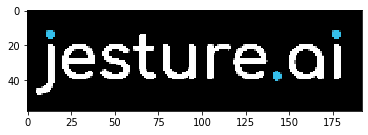

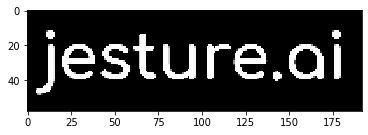

In [7]:
def to_np(pil_img):
    return np.array(pil_img)[...,None]

design_root = '/Users/izakharkin/Desktop/deepjest/_design'
logo_path = f'{design_root}/wix/jesture_ai_logo_comfortaa/jesture_logo_comfortaa-removebg.png'
img = Image.open(logo_path, 'r')
has_alpha = img.mode == 'RGBA'
print(has_alpha)
red, green, blue, alpha = img.split()
print(np.array(alpha).shape)

logo_img = np.concatenate([to_np(red), to_np(green), to_np(blue)], axis=-1)
logo_img = logo_img[250:-250,:,:]  # remove odd borders
orig_size = (logo_img.shape[1], logo_img.shape[0])
print('orig_size:', orig_size)
target_size = (orig_size[0] // 10, orig_size[1] // 10)
print('target_size:', target_size)
logo_img = cv2.resize(logo_img, target_size)

logo_alpha = to_np(alpha)
logo_alpha = logo_alpha[250:-250,:,:]  # remove odd borders
logo_alpha = cv2.resize(logo_alpha, target_size)

plt.imshow(logo_img);
plt.show();
plt.imshow(logo_alpha, cmap='gray');
plt.show();

In [8]:
testimg = io.imread('./test.jpg')

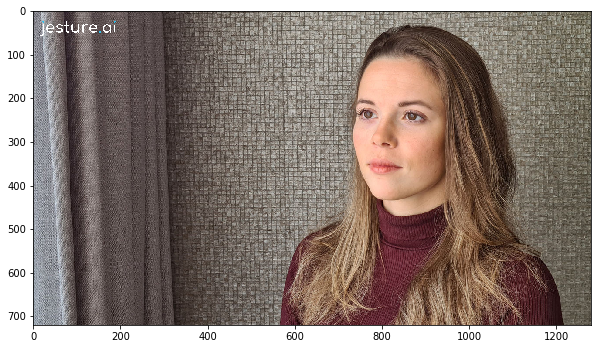

In [9]:
testimg = overlay_alpha(logo_img, logo_alpha, testimg, loc=(10, 10), alpha=1.0)
plt.figure(figsize=(10, 7))
plt.imshow(testimg);

(MainThread) STREAM b'IHDR' 16 13
(MainThread) STREAM b'IDAT' 41 4943


orig_size: (960, 540)
target_size: (137, 77)


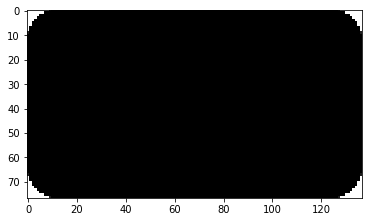

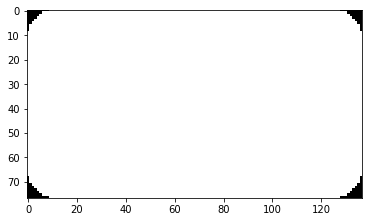

In [10]:
blackbox = io.imread('./blackbox.png')
orig_size = (blackbox.shape[1], blackbox.shape[0])
print('orig_size:', orig_size)
target_size = (orig_size[0] // 7, orig_size[1] // 7)
print('target_size:', target_size)
blackbox = cv2.resize(blackbox, target_size)
plt.imshow(blackbox);
plt.show();
blackbox_alpha = np.ones_like(blackbox)[:,:,0] * 255
blackbox_alpha[blackbox[:,:,0] == 255] = 0
plt.imshow(blackbox_alpha, cmap='gray');
plt.show();

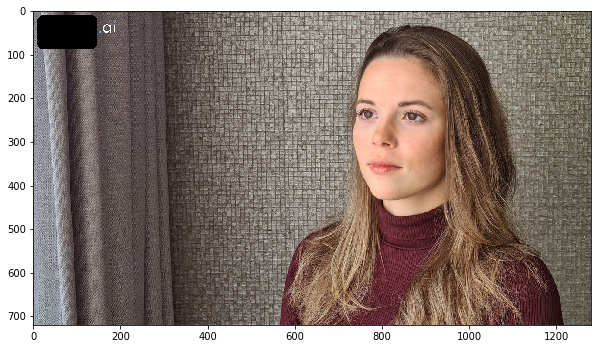

In [11]:
testimg = overlay_alpha(blackbox, blackbox_alpha, testimg, loc=(10, 10), alpha=1.0)
plt.figure(figsize=(10, 7))
plt.imshow(testimg);

## Demo

In [12]:
def daemon():
    logging.debug('Starting')
    run_full_cpu(instance)
    logging.debug('Exiting')

In [13]:
instance = create_full_cpu(1)
print(instance)
d = threading.Thread(name='daemon', target=daemon)
d.setDaemon(True)
d.start()

(daemon    ) Starting


In [14]:
# stop_full_cpu(instance)

In [15]:
name = 'JestureSDK: Python Demo'
width, height = (640, 480)
# cv2.namedWindow(name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(name, (width, height))
# cv2.startWindowThread()

logo_loc = (10, 10)
left_box_loc = (64, 360)
left_text_loc = (64, 400)
right_box_loc = (480, 360)
right_text_loc = (480, 400)
dynamic_text_loc = ((left_text_loc[0]+right_text_loc[0])//2, 50)

cap = WebcamVideoStream(src=1, width=width, height=height)
cap.start()

selfie_mode = True
i = 0
while(True):
    if cap.frame is None:
        continue
    frame = cap.frame[:,::-1,:] if selfie_mode else cap.frame  # TODO: read frames from dylib
    frame = overlay_alpha(logo_img[:,:,::-1], logo_alpha, frame, loc=logo_loc, alpha=1.0)
    frame = overlay_alpha(blackbox, blackbox_alpha, frame, loc=left_box_loc, alpha=1.0)
    frame = overlay_alpha(blackbox, blackbox_alpha, frame, loc=right_box_loc, alpha=1.0)
#     frame = blur_image_patch(frame, xmin=40, ymin=300, ymax=400, xmax=180)
    dynamic_gesture = get_dynamic_gesture(instance).decode()
    left_gesture = get_static_left_gesture(instance).decode()
    right_gesture = get_static_right_gesture(instance).decode()
    frame = draw_text(frame, dynamic_gesture, org=dynamic_text_loc, 
                      color=(0,0,0), fontScale=0.75)
    frame = draw_text(frame, left_gesture, org=left_text_loc,
                      color=(255,255,255), fontScale=0.75)
    frame = draw_text(frame, right_gesture, org=right_text_loc,
                      color=(255,255,255), fontScale=0.75)
    cv2.imshow(name, frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        stop_full_cpu(instance)
        break
    i += 1

(daemon    ) Exiting


In [ ]:
d.join()

print(instance)
dispose_full_cpu(instance)
print(instance)

cap.stop()

# cv2.waitKey(1)
# cv2.destroyAllWindows()
# cv2.waitKey(1)